_this is an R notebook_

#Introduction

This Notebook (the first-of-four) serves to introduce a user to a series of exercises focused on *higher order* **_Trend Surface analysis with R_**.

It consists of two sections:

<ol type = "1">
    <li>Explore the dataset</li>
    <li>Deterministic Interpolation Techniques</li>
  </ol>



<div class="alert alert-block alert-danger"><b>REQUIRED: </b></div>

**You are required to insert your outputs and any comment into this document.** The document you submit should therefore contain the existing text in addition to:

> *   Plots and other outputs from executing the code chunks  
> *   Discussion of your plots and other outputs as well as conclusions reached.

This should also include any hypotheses and assumptions made as well as factors that may affect your conclusions.

## 1. Explore the Dataset

_please install necessary packages through a `prompt` interface. Not here_.

In [ ]:
options(prompt="> ", continue="+ ", digits=3, width=70, show.signif.stars=T, repr.plot.width=8, repr.plot.height=8)
rm(list=ls())

# Install necessary packages: You only need to run this part once
##- install.packages(c("sf", "gstat", "ggplot2", "gridExtra","units", "terra","mgcv","fields","nlme"))

#library(repr)
library(sf) # 'simple features' representations of spatial objects
library(gstat) # geostatistics
library(ggplot2) # Grammer of Graphics plots
library(gridExtra) # arrange multiple ggplot graphics on one figure
library(units) # units of measure
library(terra) # gridded data structures ("rasters")
#library(mgcv) # for Generalized Additive Models
#library(fields) # NCAR etc. approach to surfaces
#library(nlme) # Linear and Nonlinear Mixed Effects Models#

Warning message:
"package 'fields' was built under R version 3.6.3"Loading required package: viridis
Warning message:
"package 'viridis' was built under R version 3.6.3"

ERROR: Error: package 'viridisLite' 0.3.0 was found, but >= 0.4.0 is required by 'viridis'


In [ ]:
options(show.signif.stars=FALSE)

In [ ]:
file = 'cptFlatsAquifer_watertable4.txt'

In [ ]:
#-- import
cfaq <- read.csv(file, header = 1, sep = ',', dec = '.') #sep = '\t',

In [ ]:
#-- look
head(cfaq ,3)

name,long,lat,waterLevel,elevation,depth
EM_01,18.6,-34.1,14.4,20.4,63
EM_27,18.6,-34.1,16.2,20.0,48
EM_29,18.6,-34.1,18.8,25.5,39


<div class="alert alert-block alert-warning"><b>QUESTION: </b> </div>

- What is the purpose of producing a map of the the elevation of the top of the aquifer over the study area? In other words, who would use the map and for what purpose?

> [double click in this cell and type your answer here]

In [ ]:
#names(cfaq) <- c("name", "long", "lat", "wl", "z", "d")
str(cfaq)

'data.frame':	28 obs. of  6 variables:
 $ name      : Factor w/ 28 levels "BCH_BH1","CR18_1",..: 4 15 16 9 12 8 3 2 11 20 ...
 $ long      : num  18.6 18.6 18.6 18.7 18.6 ...
 $ lat       : num  -34.1 -34.1 -34.1 -34 -34 ...
 $ waterLevel: num  14.4 16.2 18.8 20.1 22.9 ...
 $ elevation : num  20.4 20 25.5 36.5 32.7 ...
 $ depth     : num  63 48 39 45 33 33 27 27 37 26 ...


In [ ]:
#- set as a spatial feature with xy coords an existing projection
cfaq.sf <- st_as_sf(cfaq, coords=c("long", "lat"), crs = 4326) #wgs84
#str(cfaq)
st_crs(cfaq.sf)

Coordinate Reference System:
  User input: EPSG:4326 
  wkt:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["Horizontal component of 3D system."],
        AREA["World."],
        BBOX[-90,-180,90,180]],
    ID["EPSG",4326]]

In [ ]:
#- transform to local crs
cfaq.sf <- st_transform(cfaq.sf, crs = 32734) #utm 34s

In [ ]:
str(st_coordinates(cfaq.sf))

 num [1:28, 1:2] 274222 276191 279770 283452 282454 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:28] "1" "2" "3" "4" ...
  ..$ : chr [1:2] "X" "Y"


In [ ]:
#- summarize the coordinates
summary(st_coordinates(cfaq.sf), digits = 3)

       X                Y          
 Min.   :264519   Min.   :6227351  
 1st Qu.:272434   1st Qu.:6233042  
 Median :275611   Median :6236837  
 Mean   :275309   Mean   :6236522  
 3rd Qu.:279043   3rd Qu.:6239690  
 Max.   :283452   Max.   :6247415  

In [ ]:
#save(aq, aq.sf, file="cfAquifer.rda")

ERROR: Error in save(aq, aq.sf, file = "aquifer.rda"): objects 'aq', 'aq.sf' not found


In [ ]:
dim(cfaq.sf)

[1] 28  5

In [ ]:
#- summarize the data
summary(cfaq.sf)

      name      waterLevel      elevation         depth      
 BCH_BH1: 1   Min.   :  4.0   Min.   :  7.1   Min.   : 14.0  
 CR18_1 : 1   1st Qu.: 15.2   1st Qu.: 19.1   1st Qu.: 32.2  
 EM-14  : 1   Median : 19.4   Median : 25.4   Median : 39.0  
 EM_01  : 1   Mean   : 27.4   Mean   : 32.7   Mean   : 39.9  
 EM_08  : 1   3rd Qu.: 33.3   3rd Qu.: 35.3   3rd Qu.: 42.8  
 EM_09  : 1   Max.   :105.8   Max.   :130.0   Max.   :102.0  
 (Other):22                                                  
          geometry 
 POINT        :28  
 epsg:32734   : 0  
 +proj=utm ...: 0  
                   
                   
                   
                   

In [ ]:
#- bounding box
st_bbox(cfaq.sf)

   xmin    ymin    xmax    ymax 
 264519 6227351  283452 6247415 

In [ ]:
#- a couple of range measurments
range(cfaq.sf$waterLevel); diff(range(cfaq.sf$waterLevel))
range(cfaq.sf$elevation); diff(range(cfaq.sf$elevation))
range(cfaq.sf$depth); diff(range(cfaq.sf$depth))

[1]   4 106

[1] 102

<div class="alert alert-block alert-warning"><b>QUESTIONS: </b> </div>

- How many observations are there? What was recorded at each point?

> [double click in this cell and type your answer here]

- What are the geographic limits of the study area? What is its area, in km2?

> [double click in this cell and type your answer here]

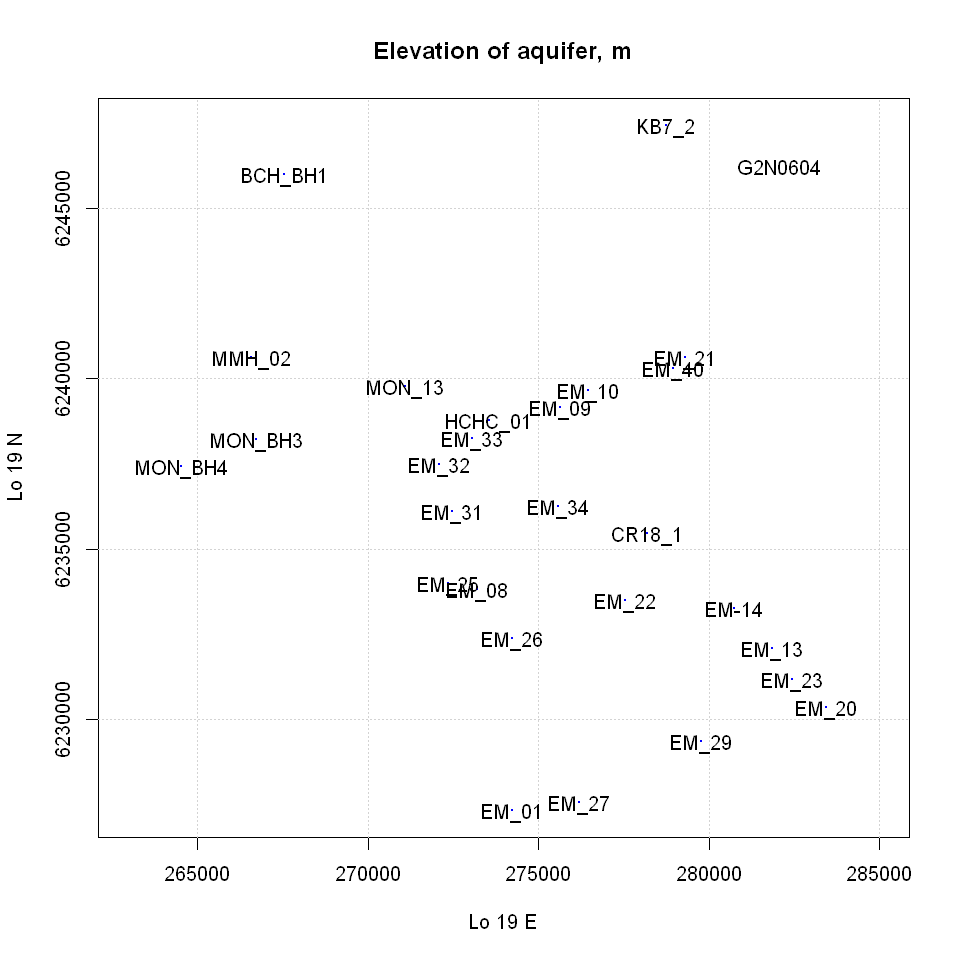

In [ ]:
plot(st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
#plot(st_coordinates(cfaq.sf)[,1] ~ st_coordinates(cfaq.sf)[,2],
     pch=20, cex=0.4, col="blue", asp=1,
     xlab="Lo 19 E", ylab="Lo 19 N")
grid()
text(st_coordinates(cfaq.sf)[,1], st_coordinates(cfaq.sf)[,2],
     #st_coordinates(cfaq.sf)[,2], st_coordinates(cfaq.sf)[,1],
     #round(cfaq$waterLevel), adj=c(0.5,0.5))
     cfaq$name, adj=c(0.5,0.5))
#text(cfaq$E, cfaq$N, round(aq$z), adj=c(0.5,0.5))
title("Elevation of aquifer, m")

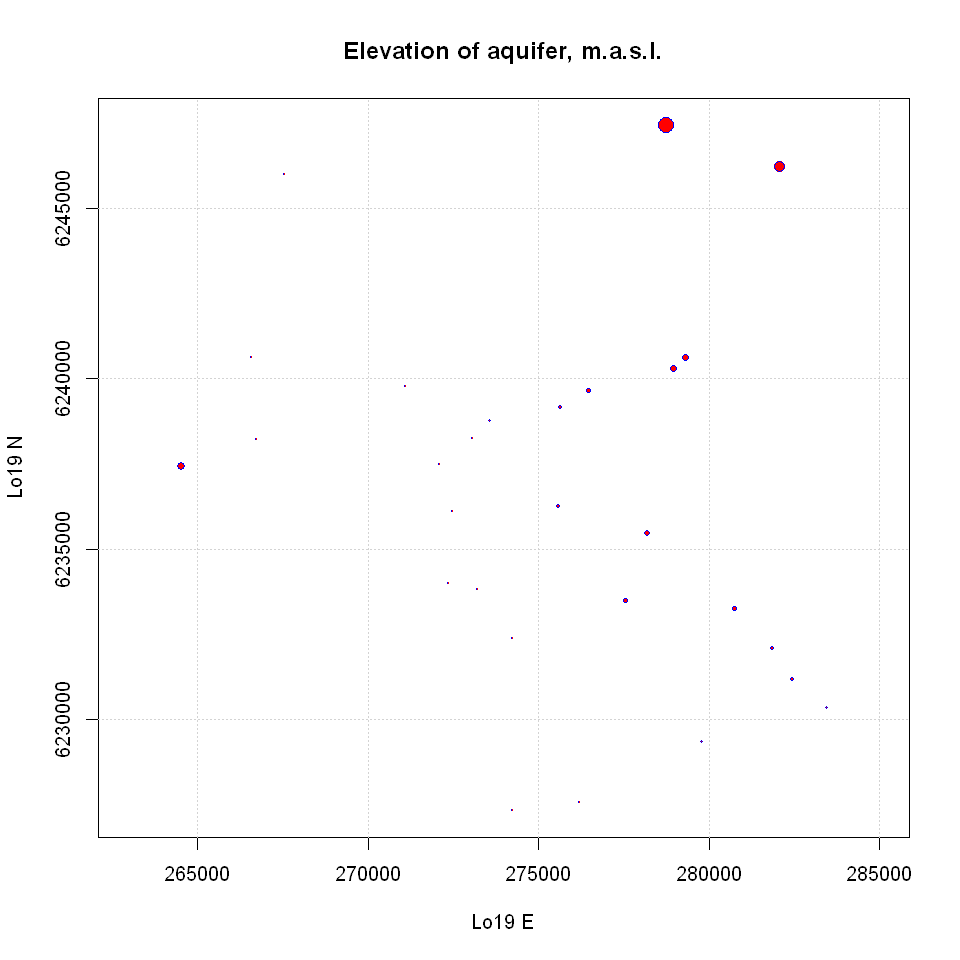

In [ ]:
plot(#st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
     st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
     cex=0.8*cfaq$waterLevel/max(cfaq$waterLevel),
     col="blue", bg="red", pch=21, asp=1,
     xlab="Lo19 E", ylab="Lo19 N")
grid()
title("Elevation of aquifer, m")

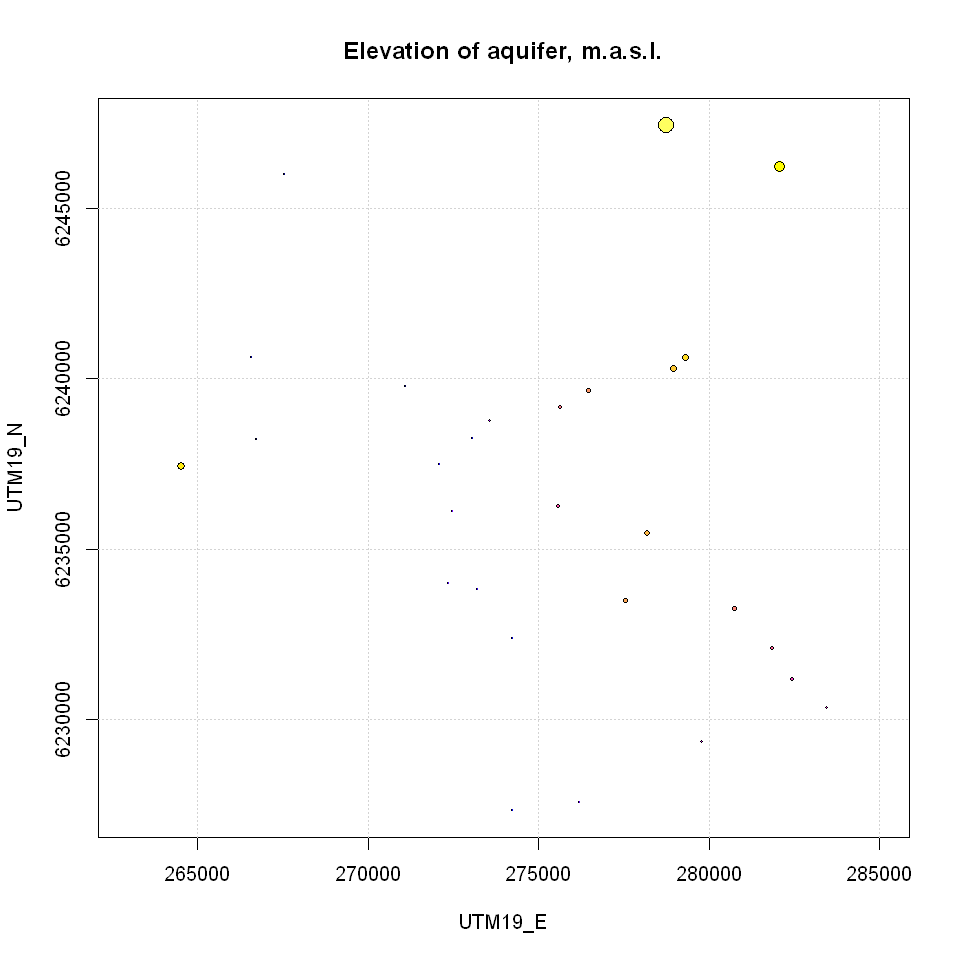

In [ ]:
plot(#st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
     st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
     pch=21,
     xlab="UTM19_E", ylab="UTM19_N",
     bg=sp::bpy.colors(length(cfaq$waterLevel))[rank(cfaq$waterLevel)],
     cex=0.8*cfaq$waterLevel/max(cfaq$waterLevel), asp=1)
grid()
title("Elevation of aquifer, m")

<div class="alert alert-block alert-warning"><b>QUESTIONS: </b> </div>

- Describe the spatial pattern of the elevations. Do nearby points have similar values? Is there a trend across the whole area? Are there local exceptions to the trend?

> [double click in this cell and type your answer here]

<div class="alert alert-block alert-danger"><b>stop here! </b></div>

# 2. Deterministic Approches to Interpolation

  Before we delve into **higher order interpolation Techniques**; let us first explore two extremly useful methods we can use to model a continuous variable _(like an elevation surface or meterological observations)_.
  <ol type = "a">
    <li>Thiessen Polygons</li>
    <li>Inverse Distance Weighting (IDW)</li>
  </ol>

  _Remember our goal is to estimate values where non exist. And depending on the application (and the data we have access to) higher order methods might not be necessary!_

**a. Thiessen Polygons**

  The oldest method is simply to divide the area of interest based on proximity to sample points. The result is a tesselated surface of Thiessen polygons (_also called a Voronoi Diagram_)

In [ ]:
# Voronoi tesselation
voronoi_grid <- st_voronoi(points)

In [ ]:
#-- plot
plot(voronoi_grid, col = NA)
plot(#st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
     st_coordinates(cfaq.sf)[,2] ~ st_coordinates(cfaq.sf)[,1],
     pch=21,
     xlab="UTM19_E", ylab="UTM19_N",
     bg=sp::bpy.colors(length(cfaq$waterLevel))[rank(cfaq$waterLevel)],
     cex=0.4*cfaq$waterLevel/max(cfaq$waterLevel), asp=1)
grid()
title("Elevation of aquifer, m.a.s.l.")

**b. IDW**

An extremely popular interpolation method calculates an average value for estimated locations using values from _nearby weighted_ locations.

In [ ]:
range(st_coordinates(cfaq.sf)[,2]); range(st_coordinates(cfaq.sf)[,1])





[1] 6227351 6247415

[1] 264519 283452

In [ ]:
(n.col <- length(seq.e <- seq(min.x <- floor(min(st_coordinates(cfaq.sf)[,2])/1000)*1000,
                              max.x <- ceiling(max(st_coordinates(cfaq.sf)[,2])/1000)*1000, by=1000)))

[1] 22

In [ ]:
(n.row <- length(seq.n <- seq(min.y <- floor(min(st_coordinates(cfaq.sf)[,1])/1000)*1000,
                              max.y <- ceiling(max(st_coordinates(cfaq.sf)[,1])/1000)*1000, by=1000)))

[1] 21

In [ ]:
#we want a 2km grid
grid2km <- rast(nrows = n.row, ncols = n.col,
                xmin=min.x, xmax=max.x,
                ymin=min.y, ymax=max.y, crs = st_crs(cfaq.sf),#$proj4string,
                resolution = 2000, names="waterLevel")

values(grid2km) <- NA_real_
class(grid2km)

[1] "SpatRaster"
attr(,"package")
[1] "terra"

In [ ]:
dim(grid2km)

[1] 10 11  1

In [ ]:
summary(grid2km)

   waterLevel 
 Min.   : NA  
 1st Qu.: NA  
 Median : NA  
 Mean   :NaN  
 3rd Qu.: NA  
 Max.   : NA  
 NA's   :110  

In [ ]:
st_crs(grid2km)$crs

[1] NA

In [ ]:
st_bbox(grid2km)

ERROR: Error in UseMethod("st_bbox"): no applicable method for 'st_bbox' applied to an object of class "SpatRaster"


In [ ]:
plot(grid2km); grid()

In [ ]:
grid2km.df <- as.data.frame(grid2km, xy = TRUE, na.rm = FALSE)
names(grid2km.df)[1:2] <- c("E", "N") # match the names of the point dataset
summary(grid2km.df)


In [ ]:
# Run the IDW interpolation
# Check the effect of power (p) on the IDW interpolation
# by changing the value of "idp"

grid2km.df$idwp05 = idw(log(waterLevel)  ~ 1, grid2km, grid2km.df, idp = 0.5)$var1.pred
#meuse.grid$idwp1 = idw(log(cadmium)  ~ 1, meuse, meuse.grid, idp = 1)$var1.pred
#meuse.grid$idwp25 = idw(log(cadmium)  ~ 1, meuse, meuse.grid, idp = 2.5)$var1.pred
#meuse.grid$idwp5 = idw(log(cadmium)  ~ 1, meuse, meuse.grid, idp = 5)$var1.pred
#meuse.grid$idwp10 = idw(log(cadmium)  ~ 1, meuse, meuse.grid, idp = 10)$var1.pred

# Plot the outputs and the sample points
spplot(grid2km.df, c("idwp05"),#, "idwp1", "idwp25","idwp5", "idwp10"),
       sp.layout = list("sp.points", grid2km, col = 3, cex=.5),
       main = "Log(Water Level) - ppm , IDW Interpolation ")

In [ ]:
# Run the IDW interpolation
# Check the effect of power (p) on the IDW interpolation
# by changing the value of "idp"

meuse.grid$idwp05 = idw(log(cadmium)  ~ 1, meuse, meuse.grid, idp = 0.5)$var1.pred
meuse.grid$idwp1 = idw(log(cadmium)  ~ 1, meuse, meuse.grid, idp = 1)$var1.pred
meuse.grid$idwp25 = idw(log(cadmium)  ~ 1, meuse, meuse.grid, idp = 2.5)$var1.pred
meuse.grid$idwp5 = idw(log(cadmium)  ~ 1, meuse, meuse.grid, idp = 5)$var1.pred
meuse.grid$idwp10 = idw(log(cadmium)  ~ 1, meuse, meuse.grid, idp = 10)$var1.pred

# Plot the outputs and the sample points
spplot(meuse.grid, c("idwp05", "idwp1", "idwp25","idwp5", "idwp10"),
       sp.layout = list("sp.points", meuse, col = 3, cex=.5),
       main = "Log(Cadmium) - ppm , IDW Interpolation ")

<div class="alert alert-block alert-warning"><b>QUESTIONS: </b> </div>

- Why do we need interpolation methods that go deeper / further than the two presented here?



> [double click in this cell and type your answer]

- Comment on the quality of the IDW

<div class="alert alert-block alert-info"><b>HINT: </b>  </div>

> Think about the subjectivity of the _power_ function and what this means

> [double click in this cell and type your answer]


- How can the quality of the IDW improve?

<div class="alert alert-block alert-info"><b>HINT: </b>  </div>

> Consider the location and density of the sample (input) points

> [double click in this cell and type your answer]